In [1]:
import bz2
import os
import urllib
import MyEnsemble
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

дополнительные функции

In [2]:
def warm_predict(model, X, proba = False):
    res = []
    if isinstance(model, MyEnsemble.MyEnsemble):
        res = model.get_each_tree_votes(X)
        if proba:
            res = res
        else:
            res = res.argmax(-1)
        return res
    
    else:
        for i, est in enumerate(model.estimators_):
            if proba:
                res.append(est.predict_proba(X))
            else: 
                res.append(est.predict(X))
        res = np.array(res)
        return res

def fpt(model, X, y):
    res = model.predict(X)
    print('acc: ', accuracy_score(y, res))
    
def get_my_params(model, num_classes, warm_start, max_depth, bootstrap_seed):
    kwargs = {}
    kwargs['reg_param'] = model.reg_param
    kwargs['lr'] = model.lr 
    kwargs['num_trees'] = model.num_trees
    kwargs['num_classes'] = num_classes
    kwargs['warm_start'] = warm_start
    kwargs['max_depth'] = max_depth
    kwargs['bootstrap_seed'] = bootstrap_seed
    return kwargs
    
def dump_info(nm, model, X, num_classes = None,
              warm_start = None, max_depth = None, bootstrap_seed = None):
    d = {}
    d['labels'] = model.predict(X)
    d['proba'] = model.predict_proba(X)
    d['probs'] = warm_predict(model, X, proba = True)
    if isinstance(model, MyEnsemble.MyEnsemble):
        d['params'] =  get_my_params(model, num_classes, warm_start, max_depth, bootstrap_seed)
    else:
        d['params'] = model.get_params()
    
    path = './ModelsResults/'
    with bz2.BZ2File(path+nm+'.pbz2', 'w') as f:
        pk.dump(d, f)
    
def load_info(nm):
    path = './ModelsResults/'
    with bz2.BZ2File(path+nm+'.pbz2', 'r') as f:
        d = pk.load(f)
    return d

Data load

In [3]:
if os.path.exists('./data/X.pk') and os.path.exists('./data/y.pk'):
    X = np.load('./data/X.pk')
    y = np.load('./data/y.pk')

else:
    link = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric"
    !mkdir ./data/
    with urllib.request.urlopen(link) as f, open("./data/X.pk", "wb"), open("./data/y.pk", "wb"):
        res = f.readlines()
        for i, bs in enumerate(res):
            res[i] = [int(el) for el in bs.decode("utf-8").split(" ") if not el in {'', ' ', '\n'}]
        res = np.array(res)
    X, y = res[:, :-1], res[:, -1] - 1
    X.dump("./data/X.pk")
    y.dump("./data/y.pk")

split на 10 частей

In [4]:
coef = 0.5
splits = []
rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5,
    random_state=42)
for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    splits.append( (X_train, X_test, y_train, y_test) )

общие параметры

In [5]:
num_trees = 1000
num_classes = len(np.unique(y))

In [6]:
results = dict.fromkeys(["MY", "RF", "ADA"], None)

def dump_result(model_nm, model, split_num, X_test, results = results):
    """
    model_nm can be "MY", "RF" or "ADA"
    """
    if results[model_nm] is None:
        results[model_nm] = {}
    d = {}
    d['labels'] = model.predict(X_test)
    d['proba'] = model.predict_proba(X_test)
    d['probs'] = warm_predict(model, X_test, proba = True)
    results[model_nm][split_num] = d

обучение MyEnsemle

In [7]:
for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
    my = MyEnsemble.MyEnsemble(num_classes = num_classes, reg_param = 1.1, lr = 1.0,\
                           num_trees = num_trees, warm_start = False, max_depth = 10,\
                           verbose = 1, bootstrap_seed = 42)
    my.fit(X_train, y_train)
    fpt(my, X_test, y_test)
    dump_result("MY", my, i, X_test)
    print(">"*20)

acc:  0.768
>>>>>>>>>>>>>>>>>>>>
acc:  0.76
>>>>>>>>>>>>>>>>>>>>
acc:  0.762
>>>>>>>>>>>>>>>>>>>>
acc:  0.748
>>>>>>>>>>>>>>>>>>>>
acc:  0.784
>>>>>>>>>>>>>>>>>>>>
acc:  0.764
>>>>>>>>>>>>>>>>>>>>
acc:  0.758
>>>>>>>>>>>>>>>>>>>>
acc:  0.778
>>>>>>>>>>>>>>>>>>>>
acc:  0.774
>>>>>>>>>>>>>>>>>>>>
acc:  0.774
>>>>>>>>>>>>>>>>>>>>


обучение RF

In [8]:
for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
    rf = RandomForestClassifier(n_estimators = num_trees, criterion = 'entropy', random_state = 42,\
                                bootstrap = True, max_features = 'sqrt')
    rf.fit(X_train, y_train)
    fpt(rf, X_test, y_test)
    dump_result("RF", rf, i, X_test)
    print(">"*20)

acc:  0.766
>>>>>>>>>>>>>>>>>>>>
acc:  0.756
>>>>>>>>>>>>>>>>>>>>
acc:  0.744
>>>>>>>>>>>>>>>>>>>>
acc:  0.748
>>>>>>>>>>>>>>>>>>>>
acc:  0.77
>>>>>>>>>>>>>>>>>>>>
acc:  0.758
>>>>>>>>>>>>>>>>>>>>
acc:  0.76
>>>>>>>>>>>>>>>>>>>>
acc:  0.772
>>>>>>>>>>>>>>>>>>>>
acc:  0.786
>>>>>>>>>>>>>>>>>>>>
acc:  0.772
>>>>>>>>>>>>>>>>>>>>


обучение AdaBoost

In [9]:
for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
    dc = DecisionTreeClassifier(criterion='entropy', max_depth = 10)
    ada = AdaBoostClassifier(n_estimators = num_trees, random_state = 42, learning_rate = 1.2,\
                             base_estimator = dc)
    ada.fit(X_train, y_train)
    fpt(ada, X_test, y_test)
    dump_result("ADA", ada, i, X_test)
    print(">"*20)

acc:  0.766
>>>>>>>>>>>>>>>>>>>>
acc:  0.76
>>>>>>>>>>>>>>>>>>>>
acc:  0.748
>>>>>>>>>>>>>>>>>>>>
acc:  0.744
>>>>>>>>>>>>>>>>>>>>
acc:  0.754
>>>>>>>>>>>>>>>>>>>>
acc:  0.764
>>>>>>>>>>>>>>>>>>>>
acc:  0.764
>>>>>>>>>>>>>>>>>>>>
acc:  0.764
>>>>>>>>>>>>>>>>>>>>
acc:  0.764
>>>>>>>>>>>>>>>>>>>>
acc:  0.77
>>>>>>>>>>>>>>>>>>>>


Рисунки

In [10]:
def SAMME_R(p):
    """
    p.shape = (Est_num, X_num, Class_num)
    """
    K = p.shape[-1]
    np.clip(p, np.finfo(p.dtype).eps, None, out = p)
    log_p = np.log(p)
    H = (K - 1)*( log_p - log_p.mean(axis = 2)[:, :, np.newaxis] )
    return np.array(H) #(Est_num, X_num, Class_num)


def _inn_res(y, cum_p, auc = False):
    res = []
    for i in range(cum_p.shape[0]):
        if auc:
            res.append(roc_auc_score(y, cum_p[i, :, 1]))
        else:
            my = cum_p[i, :, :].argmax(-1)
            res.append(accuracy_score(y, my))
    return np.array(res)

        
def get_both_showres(y, p1, p2,  est_cnt, auc = False, sammer = False):
    """
    p.shape = (Est_num, X_num, Class_num)
    """
    if sammer:
        p1 = SAMME_R(p1)
        p2 = SAMME_R(p2)
    rp = np.zeros((est_cnt, p1.shape[1], p1.shape[2]))
    for i in range(est_cnt): #ms
        s1, s2 = p1[:i+1].shape[0], p2[:i+1].shape[0]
        rp[i] = (p1[:i+1].sum(0)+p2[:i+1].sum(0)) / (s1 + s2)
    return _inn_res(y, rp, auc) # (Est_num, X_num, Class_num)


def get_showres(y, p, est_cnt, auc = False, sammer = False):
    """
    p.shape = (Est_num, X_num, Class_num)
    """
    rp = np.zeros((est_cnt, p.shape[1], p.shape[2]))
    if sammer:
        p = SAMME_R(p)
    for i in range(est_cnt):
        rp[i] = p[:i+1].mean(0) 
    return _inn_res(y, rp, auc) # (Est_num, X_num, Class_num)

In [11]:
q_d_auc = dict.fromkeys(["MY", "RF", "ADA"])
q_d_bauc = dict.fromkeys(["MY with RF", "MY with ADA"])

for el in [q_d_auc, q_d_bauc]:
    for k in el.keys():
        el[k] = []

for i, (_, _, _, y_test) in tqdm(enumerate(splits), total = len(splits)):
    # one auc
    for nm in ["MY", "RF", "ADA"]:
        r = get_showres(y = y_test, p = results[nm][i]['probs'], est_cnt=num_trees,\
                        auc = True, sammer = nm == "ADA")
        q_d_auc[nm].append(r)

    # both auc
    for nm in ["RF", "ADA"]:
        r = get_both_showres(y = y_test, p1 = results["MY"][i]['probs'], p2 = results[nm][i]['probs'],\
                             est_cnt = num_trees, auc = True)
        q_d_bauc["MY with "+nm].append(r)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [12]:
q_d_acc = dict.fromkeys(["MY", "RF", "ADA"])
q_d_bacc = dict.fromkeys(["MY with RF", "MY with ADA"])

for el in [q_d_acc, q_d_bacc]:
    for k in el.keys():
        el[k] = []

for i, (_, _, _, y_test) in tqdm(enumerate(splits), total = len(splits)):
    # one acc
    for nm in ["MY", "RF", "ADA"]:
        r = get_showres(y = y_test, p = results[nm][i]['probs'], est_cnt=num_trees,\
                        auc = False, sammer = nm == "ADA")
        q_d_acc[nm].append(r)

    # both acc
    for nm in ["RF", "ADA"]:
        r = get_both_showres(y = y_test, p1 = results["MY"][i]['probs'], p2 = results[nm][i]['probs'],\
                             est_cnt = num_trees, auc = False)
        q_d_bacc["MY with "+nm].append(r)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [13]:
q_l_acc = []
for k in ["MY", "RF", "ADA"]:
    q_l_acc.append( (np.array(q_d_acc[k]).mean(0), k))

q_l_bacc = []
for k in ["MY with RF", "MY with ADA"]:
    q_l_bacc.append( (np.array(q_d_bacc[k]).mean(0), k))

q_l_auc = []
for k in ["MY", "RF", "ADA"]:
    q_l_auc.append( (np.array(q_d_auc[k]).mean(0), k))

q_l_bauc = []
for k in ["MY with RF", "MY with ADA"]:
    q_l_bauc.append( (np.array(q_d_bauc[k]).mean(0), k))

In [17]:
def spec_show(spec_l, step, indent,\
              yticks, y_nm, x_nm, colors = ['r','g','b','c--','m','y','k']):
    """
    spec_l = list[(q_l, nm)]
    """
    
    if len(spec_l) > len(colors):
        print("WRONG LEN")
        return -1
    
    f, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
    for i, (q_l, lab) in enumerate(spec_l):
        nm = lab
        if 'MY' in lab:
            nm = nm.replace("MY", 'Algorithm')
        tmp = q_l[-indent:]
        st = len(q_l) - indent + 1
        c = colors[i]
        ax1.plot(range(st, len(q_l)+1) , tmp*100, c, label = nm, linewidth = 1.5)
        ax1.set_xticks([st+i for i in range(0, len(tmp), step)] +[len(q_l),])
    
    ax1.set_yticks(yticks*100)
    ax1.grid()
    ax1.set_xlabel(x_nm, fontsize=16)
    ax1.set_ylabel(y_nm, fontsize=16)
    ax1.legend()
    
    f.show()

In [18]:
AX1_step, AX2_step, AX2_indent = 100, 200, 951

# Accuracy

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


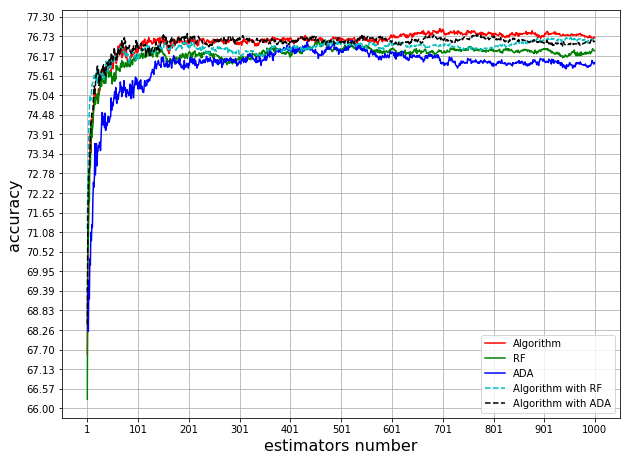

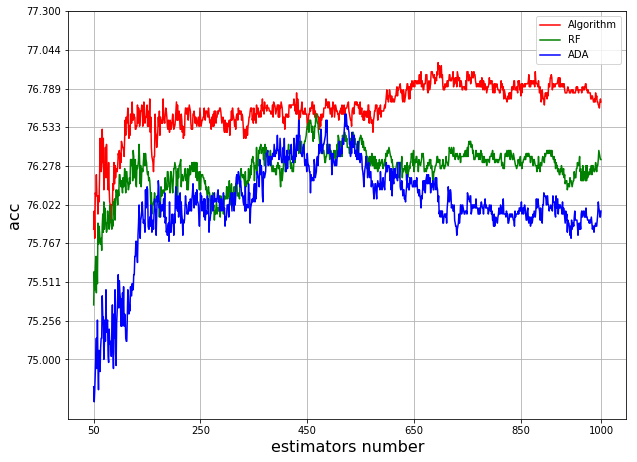

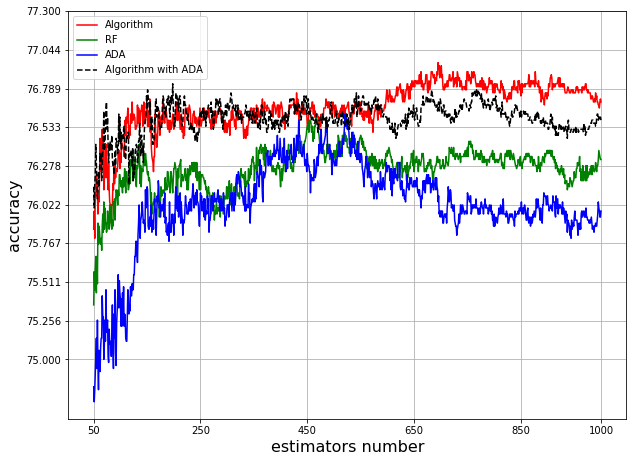

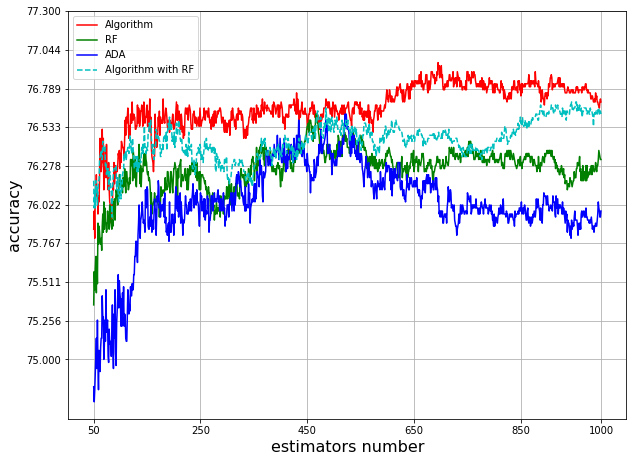

In [19]:
yticks1 = np.linspace(0.66, 0.773, 21)
yticks2 = np.linspace(0.75, 0.773, 10)

yticks = yticks1

spec_show(spec_l = q_l_acc + q_l_bacc,\
     step = AX1_step, indent = 1000, yticks = yticks,\
     y_nm = 'accuracy', x_nm = 'estimators number', colors = [ 'r', 'g', 'b','c--', 'k--'])

yticks = yticks2

spec_show(spec_l = q_l_acc,\
     step = AX2_step, indent = AX2_indent, yticks = yticks,\
     y_nm = 'acc', x_nm = 'estimators number', colors = [ 'r', 'g', 'b','c--', 'k--'])

# ADA + MY

yticks = yticks2

spec_show(spec_l = q_l_acc + q_l_bacc[1:],\
     step = AX2_step, indent = AX2_indent, yticks = yticks,\
     y_nm = 'accuracy', x_nm = 'estimators number', colors = [ 'r', 'g', 'b','k--'])

# MY + RF

yticks = yticks2

spec_show(spec_l = q_l_acc + q_l_bacc[:1],\
     step = AX2_step, indent = AX2_indent, yticks = yticks,\
     y_nm = 'accuracy', x_nm = 'estimators number', colors = [ 'r', 'g', 'b','c--', 'k--'])

# ROC-AUC

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


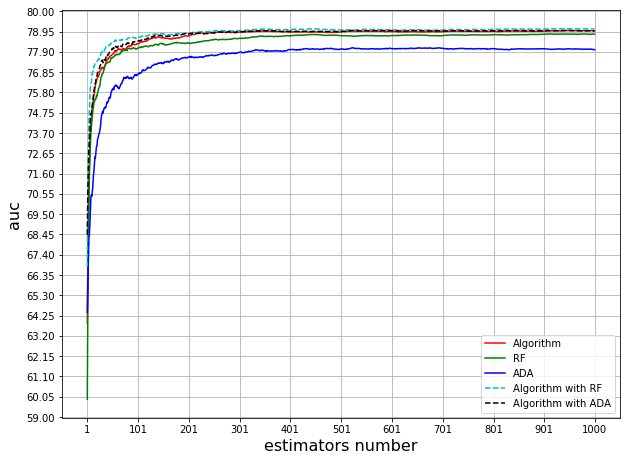

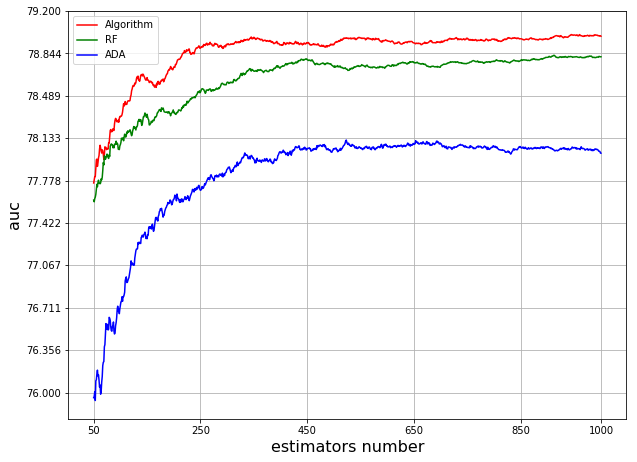

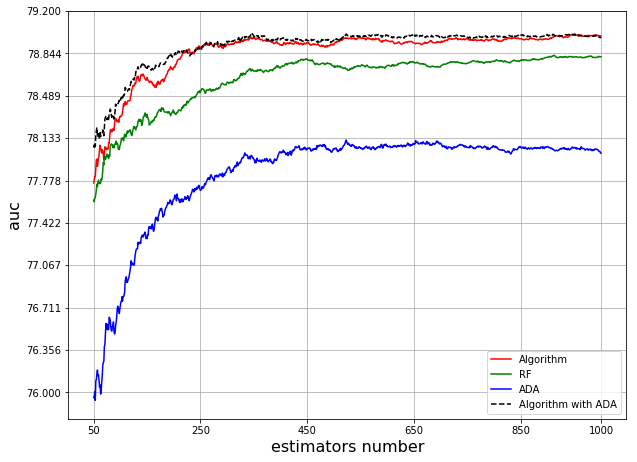

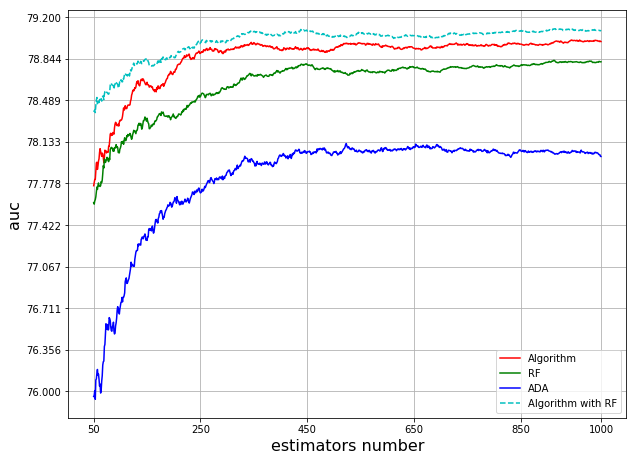

In [21]:
yticks1 = np.linspace(0.59, 0.8, 21)
yticks2 = np.linspace(0.76, 0.792, 10)

yticks = yticks1

spec_show(spec_l = q_l_auc + q_l_bauc,\
     step = AX1_step, indent = 1000, yticks = yticks,\
     y_nm = 'auc', x_nm = 'estimators number', colors = [ 'r', 'g', 'b', 'c--', 'k--'])

yticks = yticks2

spec_show(spec_l = q_l_auc,\
     step = AX2_step, indent = AX2_indent, yticks = yticks,\
     y_nm = 'auc', x_nm = 'estimators number', colors = [ 'r', 'g', 'b', 'c--', 'k--'])

# ADA + MY

yticks = yticks2

spec_show(spec_l = q_l_auc + q_l_bauc[1:],\
     step = AX2_step, indent = AX2_indent, yticks = yticks,\
     y_nm = 'auc', x_nm = 'estimators number', colors = [ 'r', 'g', 'b', 'k--'])

# MY + RF

yticks = yticks2

spec_show(spec_l = q_l_auc + q_l_bauc[:1],\
     step = AX2_step, indent = AX2_indent, yticks = yticks,\
     y_nm = 'auc', x_nm = 'estimators number', colors = [ 'r', 'g', 'b', 'c--', 'k--'])